In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

from torchvision import models
import torchvision

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# helper function
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize=(5, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()

In [3]:
# Use GPU if available, else use CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use metal for mac m1
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print(
            "MPS not available because the current PyTorch install was not "
            "built with MPS enabled."
        )
    else:
        print(
            "MPS not available because the current MacOS version is not 12.3+ "
            "and/or you do not have an MPS-enabled device on this machine."
        )

else:
    device = torch.device("mps")
    print(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


MPS not available because the current PyTorch install was not built with MPS enabled.


<h1> Prepare Data</h1>

In [7]:
import dataset

# seed rng to reproduce
torch.manual_seed(42)
batch_size=128

dataset = dataset.create_dataset()
train_size = int(0.8 * len(dataset))  # 80% of data for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print(len(dataset))
# print(len(train_loader))
# for batch_number, (inputs, labels) in enumerate(train_loader):
#     print(batch_number, inputs, labels)

100%|██████████| 4/4 [00:00<00:00, 99.01it/s]

Use pretrained inception

In [8]:
model = models.inception_v3(pretrained=True)
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False

# model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 10), nn.Linear(10, 2))
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 4))

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3
)


num_epochs = 15

for epoch in range(num_epochs):
    total_batch = len(train_dataset) // batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.to(device)
        Y = batch_labels.to(device)

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i + 1) % 5 == 0:
            print(
                "Epoch [%d/%d], lter [%d/%d] Loss: %.4f"
                % (epoch + 1, num_epochs, i + 1, total_batch, cost.item())
            )

Epoch [1/15], lter [5/80] Loss: 1.2133
Epoch [1/15], lter [10/80] Loss: 1.0749
Epoch [1/15], lter [15/80] Loss: 1.0764
Epoch [1/15], lter [20/80] Loss: 0.8808
Epoch [1/15], lter [25/80] Loss: 1.0357
Epoch [1/15], lter [30/80] Loss: 1.0530
Epoch [1/15], lter [35/80] Loss: 1.0322
Epoch [1/15], lter [40/80] Loss: 1.0094
Epoch [1/15], lter [45/80] Loss: 0.9362
Epoch [1/15], lter [50/80] Loss: 0.9861
Epoch [1/15], lter [55/80] Loss: 0.9874
Epoch [1/15], lter [60/80] Loss: 0.9248
Epoch [1/15], lter [65/80] Loss: 0.9932
Epoch [1/15], lter [70/80] Loss: 0.9323
Epoch [1/15], lter [75/80] Loss: 0.9120
Epoch [1/15], lter [80/80] Loss: 1.0063
Epoch [2/15], lter [5/80] Loss: 0.9086
Epoch [2/15], lter [10/80] Loss: 0.9105
Epoch [2/15], lter [15/80] Loss: 1.0624
Epoch [2/15], lter [20/80] Loss: 0.8212
Epoch [2/15], lter [25/80] Loss: 0.9927
Epoch [2/15], lter [30/80] Loss: 0.9733
Epoch [2/15], lter [35/80] Loss: 0.8663
Epoch [2/15], lter [40/80] Loss: 0.9227
Epoch [2/15], lter [45/80] Loss: 0.9833
Ep

Accuracy of test images: 58.125000 %
Predicted:  Non_Demented Non_Demented Non_Demented Non_Demented Non_Demented


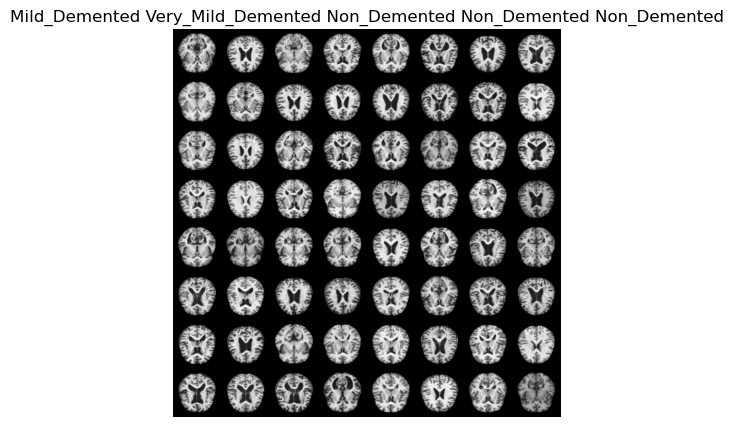

In [9]:
import ad_labels
# model = torch.load('inceptionv3v3.pt')

model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    images = images.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum()

print("Accuracy of test images: %f %%" % (100 * float(correct) / total))

classes = ad_labels.LABELS_LIST

test_iterator = iter(test_loader)
images, labels = next(test_iterator)

outputs = model(images.to(device))

_, predicted = torch.max(outputs.data, 1)

print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(5)))

title = " ".join("%5s" % classes[labels[j]] for j in range(5))
imshow(torchvision.utils.make_grid(images, normalize=True), title)

In [10]:
device

device(type='cuda')

In [11]:
# torch.save(model, 'inceptionv3v4.pt')

v1: lr 1e-3, 10, batch_siz = 128 epochs 58.046875 %
v2: lr 5e-4, 15, batch_siz = 128 epochs 57.968750 %
v3: lr 1e-3, 15, batch_siz = 128 epochs 58.359375 %
v4: lr 1e-3, 15, batch_siz = 64 epochs 58.125000 %
v5: lr 1e-3, 15, batch_siz = 256 epochs 60.468750 %
v6: lr 1e-3, 15, batch_siz = 512 epochs 56.328125 %
